# Imports

In [63]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
from celluloid import Camera
from IPython.display import HTML
from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn

# Processing

In [3]:
root = Path("/media/hacen/3a0ab16a-82f1-416c-902d-3c782e61d1ec/medicaldecathlon//Task06_Lung/")
images_path = root/"imagesTr"
saving_path = Path("Processed")

In [4]:
def change_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index('imagesTr')] = "labelsTr"
    
    return Path(*parts)

In [8]:
### Images Vizualition

In [17]:
len(list(images_path.glob('lu*')))

63

In [18]:
len(list(change_to_label_path(images_path).glob('lu*')))

63

In [15]:
example = list(images_path.glob('lu*'))[0]

In [32]:
slices = nib.load(example)
labels = nib.load(change_to_label_path(example)).get_fdata()

In [33]:
slices.shape

(512, 512, 228)

In [34]:
labels.shape

(512, 512, 228)

In [35]:
nib.aff2axcodes(slices.affine)

('L', 'A', 'S')

#### Saggital slices

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


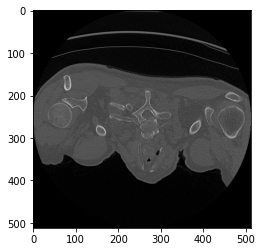

In [46]:
fig = plt.figure()
camera = Camera(fig)

for i in range(slices.shape[2]):
    slce = slices.get_fdata()[:, :, i]
    mask = labels.astype(np.uint8)
    
    mask = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, i])
    
    plt.imshow(np.transpose(slce, (1, 0)), cmap='gray')
    plt.imshow(np.transpose(mask, (1, 0)), cmap='autumn', alpha=0.7)
    camera.snap()
    
animation = camera.animate()

In [45]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


In [62]:
def normalize(volume):
    mu = volume.mean()
    std = np.std(volume)
    normalized = (volume - mu) / std
    return normalized

def normalize_and_standardize(volume):
    volume = normalize(volume)
    result = (volume - volume.min()) / (volume.max() - volume.min())
    return result

### Preprocessing

In [65]:
for c, file_path in enumerate(tqdm(list(images_path.glob("lu*")))):
    volume = nib.load(file_path).get_fdata()
    labels = nib.load(change_to_label_path(file_path)).get_fdata().astype(np.uint8)
    
    images = normalize_and_standardize(volume)
    
    train_or_val = "train" if c < 53 else "val"
    
    current_image_path = saving_path/train_or_val/str(c)/'data'
    current_label_path = saving_path/train_or_val/str(c)/'masks'
    current_image_path.mkdir(parents=True, exist_ok=True)
    current_label_path.mkdir(parents=True, exist_ok=True)
    
    for i in range(images.shape[2]):
        slce = images[:, :, i]
        mask = labels[:, :, i]
        slce = cv2.resize(slce, (256, 256), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_AREA)
        
        np.save(current_image_path/str(i), slce)
        np.save(current_label_path/str(i), mask)        

  0%|          | 0/63 [00:00<?, ?it/s]

# Dataset Model

In [ ]:
class LungTumorDataset(torch.utils.data.)